<div class="alert alert-info" role="alert">
<h2> Комментарий от автора</h2>
На локальной машине(средний ноутбук) код проекта выполняется 13 минут.
</div>

# Построение модели прогнозирования коэффициента восстановления золота из золотосодержащей руды.

## Постановка задачи:

Заказчик - Группа компаний «Цифра». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Задача - Подготовить прототип модели машинного обучения. Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды.

## Описание исходных данных:

Заказчиком предоставлены данные с параметрами добычи и очистки. Предоставленные данные уже разделенные на обучающий и тестовый наборы данных.

Путь к файлам:
- обучающий набор данных - /datasets/gold_recovery_train.csv
- тестовый набор данных - /datasets/gold_recovery_test.csv
- исходные данные - /datasets/gold_recovery_full.csv

Данные индексируются датой и временем получения информации (признак "date").
Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.

Признакам присвоены имена согласно технологическому процессу:
[этап].[тип_параметра].[название_параметра]
<br>Пример: rougher.input.feed_ag

Возможные значения для блока [этап]:
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики

Возможные значения для блока [тип_параметра]:
- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики

**признаки с типами параметров "state" и "calculation" характеризуют технологический процесс и не требуют детальной интерпретации*

Возможные значения для блока [название_параметра]:
- concentrate - доля вещества в концентрате
- recovery - эффективность обогащения
- tail - доля вещества в отвальных хвостах
- sulfate - количество сульфата (на данном производстве сульфид натрия)
- depressant - количество депрессанта (силикат натрия)
- feed size — размер гранул сырья
- xanthate - количество ксантогената (промотер, или активатор флотации)
- feed_rate — скорость подачи
- feed - количество поступаемого вещества

Целевые признаки:
- rougher.output.recovery - эффективность обогащения чернового концентрата
- final.output.recovery - эффективность обогащения финального концентрата

## Оглавление:

<br> [1. Анализ исходных данных.](#step1)
<br>  - [1.1 Проверка корректности расчета эффективности обогащения.](#step1.1)
<br>  --- [1.1.1 Вывод.](#step1.1.1)
<br>  - [1.2 Обработка дубликатов.](#step1.2)
<br>  - [1.3 Анализ структуры обучающего и тестового набора данных.](#step1.3)
<br>  - [1.4 Анализ концентрации металлов (Au, Ag, Pb) на различных этапах очистки.](#step1.4)
<br>  --- [1.4.1 Вывод.](#step1.4.1)
<br>  - [1.5 Анализ концентрации всех веществ на разных стадиях очистки.](#step1.5)
<br>  --- [1.5.1 Вывод.](#step1.5.1)
<br>  - [1.6 Сравнение распределения размеров гранул сырья на обучающем и тестовом наборе данных.](#step1.6)
<br> [2. Предобработка данных.](#step2)
<br>  - [2.1 Обработка пропущенных значений.](#step2.1)
<br>  - [2.2 Получение наборов данных согласно этапам технологического процесса.](#step2.2)
<br>  - [2.3 Проверка признаков на мультиколлинеарность.](#step2.3)
<br>  - [2.4. Отделение целевого признака от обучающих.](#step2.4)
<br>  - [2.5 Масштабирование признаков.](#step2.5)
<br> [3. Построение моделей.](#step3)
<br>  - [3.1 Функция расчета sMAPE.](#step3.1)
<br>  - [3.2 Поиск оптимальной модели и гиперпараметров.](#step3.2)
<br>  --- [3.2.1 Вывод.](#step3.2.1)
<br>  - [3.3 Расчет качества моделей на обучающем наборе данных.](#step3.3)
<br>  --- [3.3.1 Линейная регресия.](#step3.3.1)
<br>  --- [3.3.2 Дерево решений.](#step3.3.2)
<br>  --- [3.3.3 Случайный лес.](#step3.3.3)
<br>  --- [3.3.4 Вывод.](#step3.3.4)
<br>  - [3.4 Проверка моделей на тестовом наборе данных.](#step3.4)
<br>  --- [3.4.1 Вывод.](#step3.4.1)
<br> [4. Общий вывод.](#step4)


### 1. Анализ исходных данных.<a id='step1'></a>

Импорт библиотек необходимых для проведения анализа.

In [1]:
import pandas as pd # <библиотека "pandas" для работы с таблицами>
import numpy as np # <библиотека "numpy" для работы с числовыми значениями>
import matplotlib.pyplot as plt # <библиотека "matplotlib" для работы с графиками>
from sklearn.preprocessing import StandardScaler # <библиотека "sklearn" методы стандартизации>
from sklearn.model_selection import train_test_split # <библиотека "sklearn" метод для разделения наборов данных>
from sklearn.metrics import mean_squared_error # <библиотека "sklearn" метод для расчета среднеквадратичной ошибки>
import re # <библиотека для работы с регулярными выражениями>
from scipy import stats as st # <библиотека "scipy" для работы со статистическими методами>
from sklearn.model_selection import cross_val_score # <библиотека "sklearn" метод для использования кросс-валидации>
from sklearn.metrics import fbeta_score, make_scorer # <метод для использования собственных функций в качестве метрики качества>
from sklearn.dummy import DummyRegressor # < модель простых правил >
from sklearn.linear_model import LinearRegression # <библиотека "sklearn" линейная регрессия>
from sklearn.tree import DecisionTreeRegressor # < модель дерево решений >
from sklearn.ensemble import RandomForestRegressor # < модель случайный лес >
from sklearn.model_selection import GridSearchCV # < метод для поиска оптимальных гиперпараметров >
from sklearn.metrics import r2_score # <библиотека "sklearn" метрика качества r2>
from sklearn.metrics import mean_absolute_error #<библиотека "sklearn" расчет MAE>
import seaborn as sns #<импорт библиотеки "seaborn" для продвинутой работы с графиками>

Загрузка файлов с данными в переменные.

In [2]:
try: # <для работы в веб форме практикума>
    data_full = pd.read_csv('/datasets/gold_recovery_full.csv')
    data_test = pd.read_csv('/datasets/gold_recovery_test.csv')
    data_train = pd.read_csv('/datasets/gold_recovery_train.csv')
    
except: # <для работы с данными на локальной машине>  
    data_full = pd.read_csv('c:/Job/yandex ds/DS_2/project_4/gold_recovery_full.csv')
    data_test = pd.read_csv('c:/Job/yandex ds/DS_2/project_4/gold_recovery_test.csv')
    data_train = pd.read_csv('c:/Job/yandex ds/DS_2/project_4/gold_recovery_train.csv')

Для удобства работы в будущем присвоим каждой таблице имя, а так же создадим список с данными заказчика.

In [3]:
data_full.name = 'data_full'
data_test.name = 'data_test'
data_train.name = 'data_train'

source_data_list = [data_full, data_test, data_train]

#### 1.1 Проверка корректности расчета эффективности обогащения.<a id='step1.1'></a>

Перед началом дальнейшего исследования проверим корректность расчета целевого признака.
Эффективность обогащения рассчитывается по формуле:

$recovery = \frac{C*(F-T)}{F*(C-T)}*100\%$

где:
<br>C — доля золота в концентрате после флотации/очистки;
<br>F — доля золота в сырье/концентрате до флотации/очистки;
<br>T — доля золота в отвальных хвостах после флотации/очистки.

Рассчитаем эффективность флотации - признак "rougher.output.recovery".
<br>Применимо к имеющимся данным для расчета rougher.output.recovery потребуются следующие признаки:
<br> C - "rougher.output.concentrate_au" 
<br> F - "rougher.input.feed_au"
<br> T - "rougher.output.tail_au"

Создадим функцию для расчета эффективности. Функция будет получать названия столбцов в которых содержаться параметры для расчета и возвращать серию с рассчитанной по формуле эффективностью.

In [4]:
def calculate_recovery(data,C,F,T):
    C = data[C]
    F = data[F]
    T = data[T]
    result = (C*(F-T))/(F*(C-T))*100
    return result

Рассчитаем среднюю абсолютную ошибку (MAE) между значением в столбце "rougher.output.recovery_calc" и рассчитанными по формуле. Функция "mean_absolute_error" может работать только с массивами без пропущенных значений. Проведем эксперимент на обучающем наборе данных. Скопируем таблицу и удалим из нее все строки содержащие пропущенные значения. 

In [5]:
data_train_recovery_mae = data_train.copy()
data_train_recovery_mae = data_train_recovery_mae.dropna()

Используя функцию рассчитаем эффективность.

In [6]:
calculate_recovery = calculate_recovery(data_train_recovery_mae,
                                        'rougher.output.concentrate_au',
                                        'rougher.input.feed_au',
                                        'rougher.output.tail_au')

Рассчитаем среднюю абсолютную ошибку.

In [7]:
mean_absolute_error(data_train_recovery_mae['rougher.output.recovery'],calculate_recovery)

9.555596961987514e-15

##### 1.1.1 Вывод.<a id='step1.1.1'></a>

Значение средней абсолютной ошибки между предоставленными заказчиком данными и расчетными настолько мало, что можно считать значения одинаковыми.
Предоставленные данные по эффективности корректны.

#### 1.2 Обработка дубликатов. <a id='step1.2'></a>

Проверим наличие полностью дублирующих друг друга строк в наших таблицах. Для этого воспользуемся функцией "duplicated()" и посчитаем сумму строк функцией "sum()".

In [8]:
for data in source_data_list:
    print(f'Количество полностью дублирующихся строк в таблице "{data.name}": {data.duplicated().sum()}')

Количество полностью дублирующихся строк в таблице "data_full": 0
Количество полностью дублирующихся строк в таблице "data_test": 0
Количество полностью дублирующихся строк в таблице "data_train": 0


#### 1.3 Анализ структуры обучающего и тестового набора данных. <a id='step1.3'></a>

Рассмотрим структуру таблиц.

In [9]:
for data in source_data_list:
    print(f'Размер таблицы {data.name}:{data.shape}')

Размер таблицы data_full:(22716, 87)
Размер таблицы data_test:(5856, 53)
Размер таблицы data_train:(16860, 87)


В тестовом наборе данных количество признаков отличается. Получим список столбцов которых нет в тестовом наборе данных.

In [10]:
data_test_missing_columns = list(set(list(data_full)) - set(list(data_test)))

По технологическому процессу не все признаки могут быть использованы моделью. Некоторые признаки можно получить только после анализа финальных сплавов. Тестовый набор данных содержит только те признаки, которые должна использовать модель при работе. В тестовом наборе данных отсутствуют целевые признаки.

Для проверки качества модели необходимо дополнить тестовый набор данных целевыми признаками "rougher.output.recovery" и "final.output.recovery". Скопируем список "data_test_missing_columns" и удалим из копии указания на целевые признаки.

In [11]:
data_test_missing_columns_no_target = data_test_missing_columns.copy()
data_test_missing_columns_no_target.remove('rougher.output.recovery')
data_test_missing_columns_no_target.remove('final.output.recovery')

Создадим копию таблицы "data_train", но без столбцов из списка "data_test_missing_columns_no_target".

In [12]:
data_train_updated = data_train.copy()
data_train_updated = data_train_updated.drop(data_test_missing_columns_no_target, 
                                             axis=1)

Создадим копию таблицы "data_test" и дополним ее целевыми признаками из исходного набора данных "data_full". Обогащение будет выполняться методом "merge". В качестве индекса будем использовать столбец "date".

In [13]:
data_test_updated = data_test.copy()
data_test_updated = data_test_updated.merge(data_full[['date',
                                                       'final.output.recovery',
                                                       'rougher.output.recovery']], 
                                            on='date', 
                                            how='left')

Для дальнейшего удобства переименуем таблицы и создадим новый список с обновлёнными таблицами.

In [14]:
data_test_updated.name = 'data_test_updated'
data_train_updated.name = 'data_train_updated'

source_data_updated_list = [data_test_updated, data_train_updated]

#### 1.4 Анализ концентрации металлов (Au, Ag, Pb) на различных этапах очистки.<a id='step1.4'></a>

От заказчика поступило требование исследовать концентрацию металлов на различных стадиях очистки. Используя исходный набор данных рассчитаем среднее значение по всем признакам. После расчета среднего значения сбросим индексы и присвоим столбцам удобные имена.

In [15]:
data_full_mean = data_full.mean()
data_full_mean = data_full_mean.reset_index()
data_full_mean.columns = ['stage','value']

Создадим списки для упорядочивания этапов очистки согласно технологическому процессу. 
<br>Список "state_concentrate" будет содержать стадии при которых выделяются элементы. 
<br>Список "state_tail" содержит стадии при которых отделяются отвалы. 
<br>Список "metals" содержит металлы для исследования.

In [16]:
state_concentrate = ['rougher.input',
                     'rougher.output.concentrate',
                     'primary_cleaner.input',
                     'primary_cleaner.output.concentrate',
                     'final.output.concentrate']

state_tail = ['rougher.input', 
              'rougher.output.tail',
              'primary_cleaner.output.tail',
              'secondary_cleaner.output.tail',
              'final.output.tail']

metals = ['ag','au','pb']

Напишем функцию для сортировки значений согласно этапу технологического процесса. 
Функция принимает в качестве параметров:
- DataFrame со столбцами "stage" и "value".
- Упорядоченный согласно технологическому процессу список этапов.
- Список элементов.
- Словарь в который будут сохранены отсортированные данные.

Функция в несколько циклов обрабатывает строки в исходном DataFrame согласно спискам "elements_list" и "stage_list". Если найдена строка, которая начинается с элемента списка "stage_list" и заканчивается элементом списка "elements_list", то она сохраняется в словарь "result_dict".

In [17]:
def sort_elements_by_stage (data, stage_list, elements_list, result_dict):
    for element in elements_list:
        local_dict = {}
        local_dict['stage'] = []
        local_dict[element] = []
        
        for state in stage_list:
            for index, row in data.iterrows():
                if row['stage'].startswith(state) and row['stage'].endswith(element):
                    local_dict[element].append(row['value'])
                    local_dict['stage'].append(row['stage'])
                    result_dict[element]=pd.DataFrame(local_dict)    

<div class="alert alert-info" role="alert">
<h2> Комментарий от автора</h2>
Альтернативная доработанная функция по рекомендации преподавателя. Указан в двух необрабатываемых блоках ниже.
</div>

Создадим два пустых словаря в которых будут содержаться данные по содержанию металлов после очистки и в отвалах.

In [18]:
metals_concentrate_dict = {}
metals_tail_dict= {}

Дважды выполним функцию для каждого из ранее созданных словарей.

In [19]:
sort_elements_by_stage(data_full_mean,state_concentrate,metals,metals_concentrate_dict)
sort_elements_by_stage(data_full_mean,state_tail,metals,metals_tail_dict)

In [20]:
metals_concentrate_dict

{'ag':                                    stage         ag
 0                  rougher.input.feed_ag   8.065715
 1          rougher.output.concentrate_ag  10.874484
 2  primary_cleaner.output.concentrate_ag   7.691652
 3            final.output.concentrate_ag   4.781559,
 'au':                                    stage         au
 0                  rougher.input.feed_au   7.565838
 1          rougher.output.concentrate_au  17.879538
 2  primary_cleaner.output.concentrate_au  29.212289
 3            final.output.concentrate_au  40.001172,
 'pb':                                    stage        pb
 0                  rougher.input.feed_pb  3.305676
 1          rougher.output.concentrate_pb  6.900646
 2  primary_cleaner.output.concentrate_pb  8.921110
 3            final.output.concentrate_pb  9.095308}

Напишем функцию для построения графиков по данным из словарей.

In [21]:
def plot_from_dict(data_dict):
    for data in data_dict:
        data_dict[data].plot(x='stage', kind='bar', 
                    alpha=0.3,
                    figsize=(10,3), 
                    sharex=False)
        plt.xlabel('Этап технологического процесса', fontsize=10)
        plt.ylabel('Количество элемента в пробе',fontsize=10)
        plt.title(f'Количество элемента "{data}" на этапах технологического процесса', fontsize=20)
        plt.xticks(rotation=30,fontsize=8)
        plt.grid()
        plt.show()

Построим графики концентрации металлов после очистки.

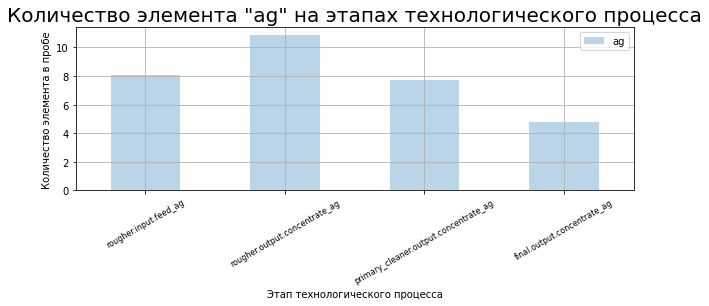

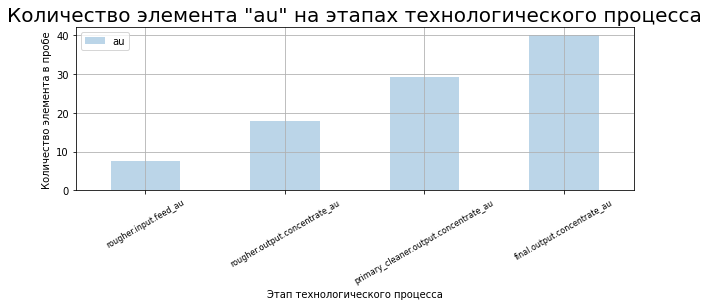

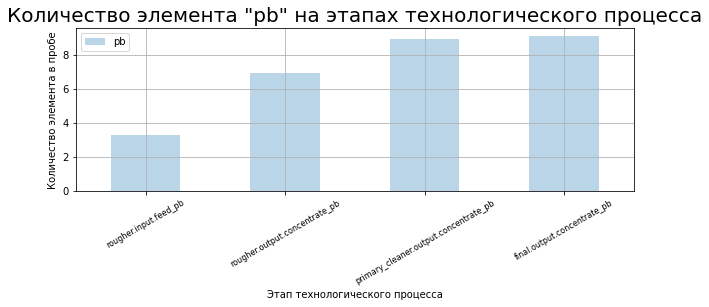

In [22]:
plot_from_dict(metals_concentrate_dict)

Построим графики концентрации металлов в отвалах.

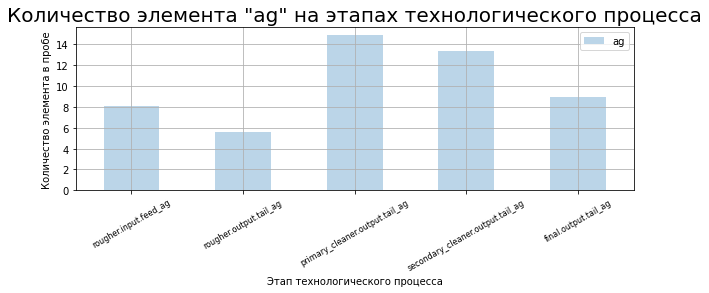

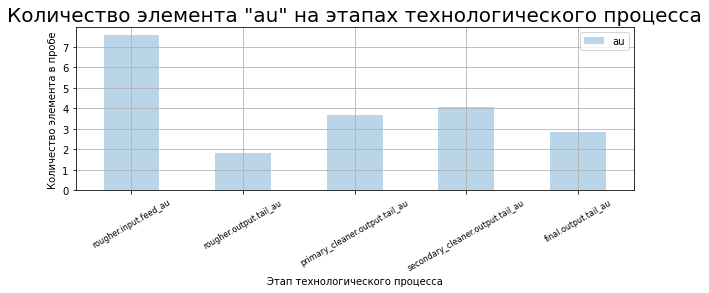

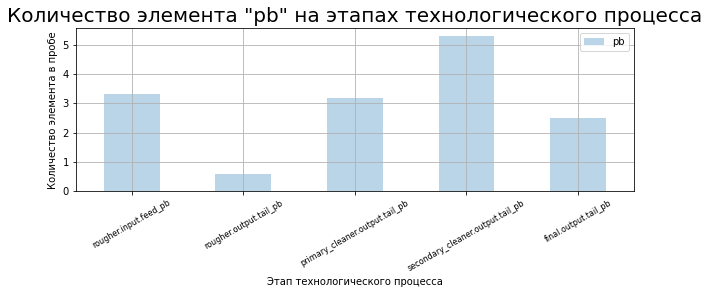

In [23]:
plot_from_dict(metals_tail_dict)

##### 1.4.1 Вывод.<a id='step1.4.1'></a>

Золото:
На каждом этапе очистки количество золота в пробах значительно увеличивается. После финальной стадии очистки количество золота в пробах в среднем увеличилось более чем в четыре раза.
В среднем количество золота в отвалах значительно снижается относительно изначального количества в руде. При этом после каждого этапа очистки количество золота в отвалах примерно одинаковое. Незначительное увеличение количества золота в отвалах после первичной очистки можно связать с увеличением количества золота в концентрате который попадает на первичную очистку.

Серебро:
Относительно содержания в исходном сырье среднее количество серебра в концентрате после флотации увеличивается. На последующих этапах содержание серебра в концентрате падает.
После первой стадии очистки количество серебра в отвалах резко увеличивается и становиться больше чем в исходном сырье.
На всех этапах кроме флотации количество серебра в отвалах больше чем в исходном сырье.

Свинец:
Количество свинца в концентрате на всех стадиях очистки увеличивается относительно содержания в исходном сырье.
Количество свинца в отвалах меняется не линейно. Больше всего свинца в отвалах после второго этапа очистки.

#### 1.5 Анализ концентрации всех веществ на разных стадиях очистки.<a id='step1.5'></a>

От заказчика поступило требование исследовать распределение веществ в сырье, в черновом и финальном концентратах.
Подготовим список с реагентами, которые используются при очистке.

In [24]:
reagents = ['sol', 'sulfate', 'depressant', 'xanthate' ]

Объединим список металлов и реагентов.

In [25]:
all_elements = metals.copy()
all_elements.extend(reagents)

Напишем функцию по аналогии с "sort_elements_by_stage". 
<br>Функция "values_by_stage" принимает в качестве параметров: 
- DataFrame с исходными данными.
- Упорядоченный согласно технологическому процессу список этапов.
- Список элементов.
- Словарь в который будут сохранены отсортированные данные.

Функция отбирает столбцы из списка "stage_list" и сохраняет в словарь "result_dict" столбцы по каждому элементу из списка elements_list".

In [26]:
def values_by_stage (data, stage_list, elements_list, result_dict):
    
    for state in stage_list:
        local_dict = {}
        local_dict[state] = {}
        for element in elements_list:    
            for stage in data:
                if stage.startswith(state) and stage.endswith(element):
                    local_dict[state][element] = data[stage]
                    result_dict[state] = pd.DataFrame(local_dict[state])

Создадим пустой словарь "values_concentrate_dict" в котором будут содержаться DataFrame с упорядоченными признаками.

In [27]:
values_concentrate_dict = {}

Исследуем исходный набор данных "data_full". Передадим функции таблицу с данными, список этапов очистки "state_concentrate" и список элементов "all_elements". 

In [28]:
values_by_stage(data_full, state_concentrate, all_elements, values_concentrate_dict)

Отобразим гистограммы распределения величин на различных этапах.

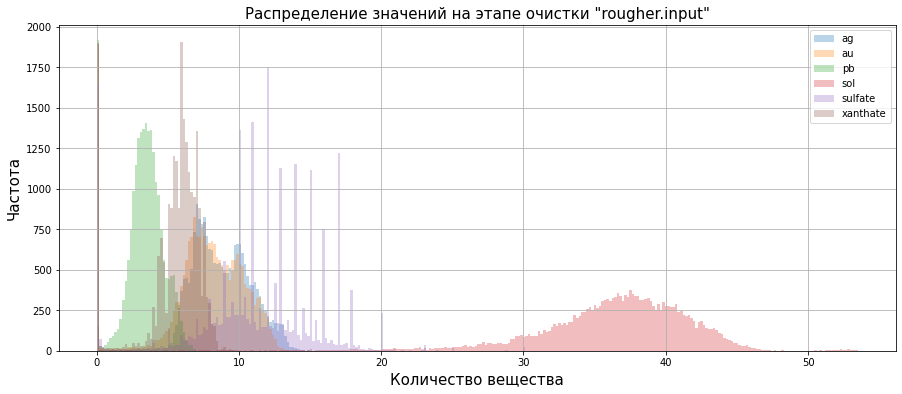

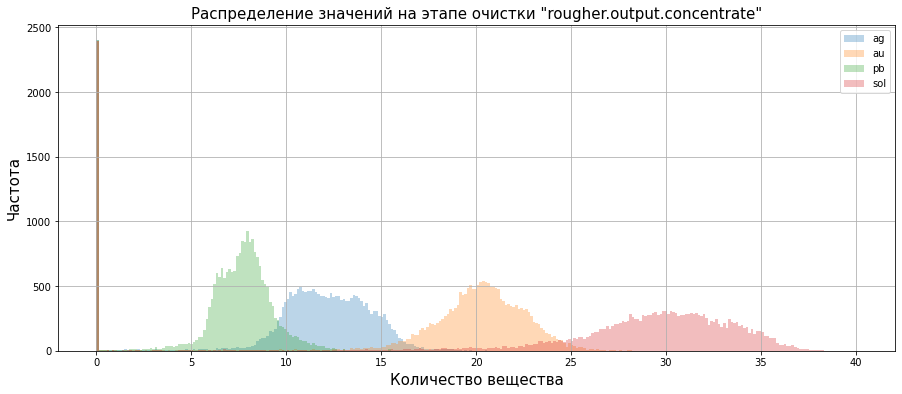

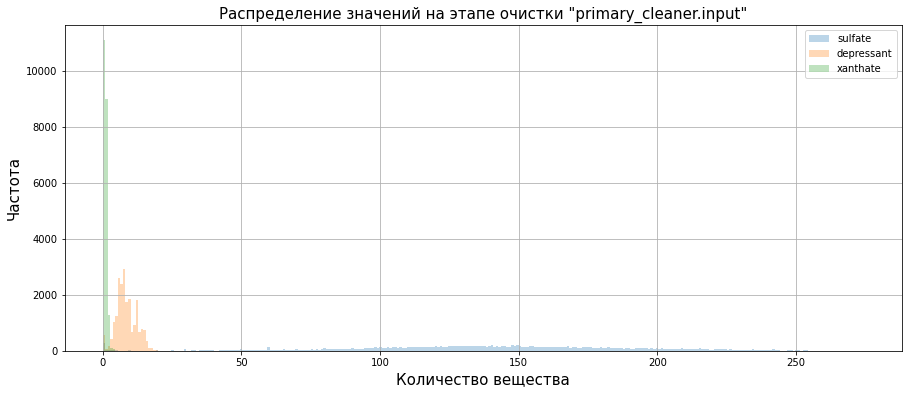

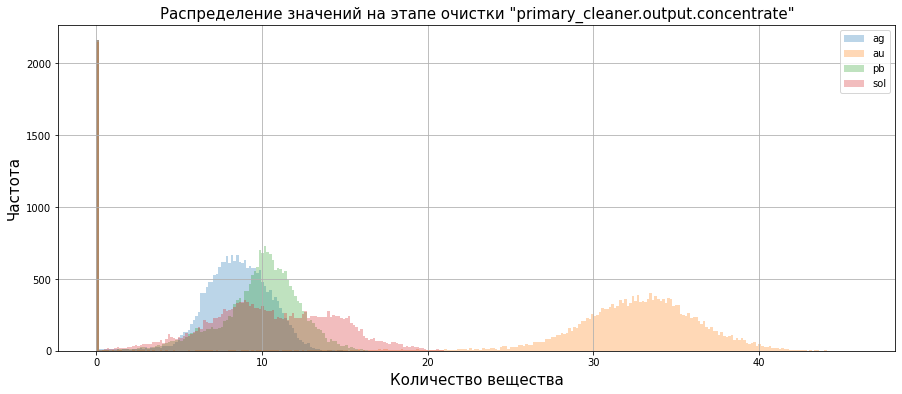

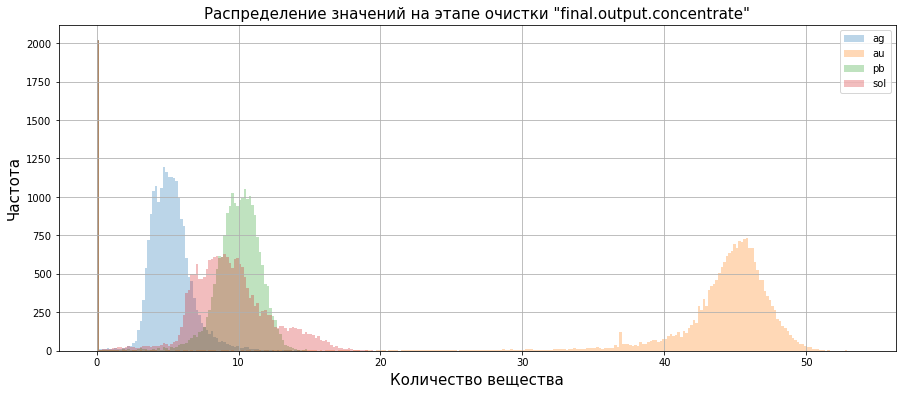

In [29]:
for data in values_concentrate_dict:
    values_concentrate_dict[data].plot(kind = 'hist', figsize=(15,6),bins = 300, alpha=0.3)
    plt.xlabel('Количество вещества', fontsize=15)
    plt.ylabel('Частота',fontsize=15)
    plt.title(f'Распределение значений на этапе очистки "{data}"', fontsize=15)
    plt.grid()
    plt.show()

Судя по гистограммам в исходном наборе данных присутствует большое количество значений близких к нулевому. Можно предположить, что это обусловлено отсутствием вещества в начале процесса очистки. Ограничим диапазон отображения данных на графике, и более детально рассмотрим значения близкие к нулевым.

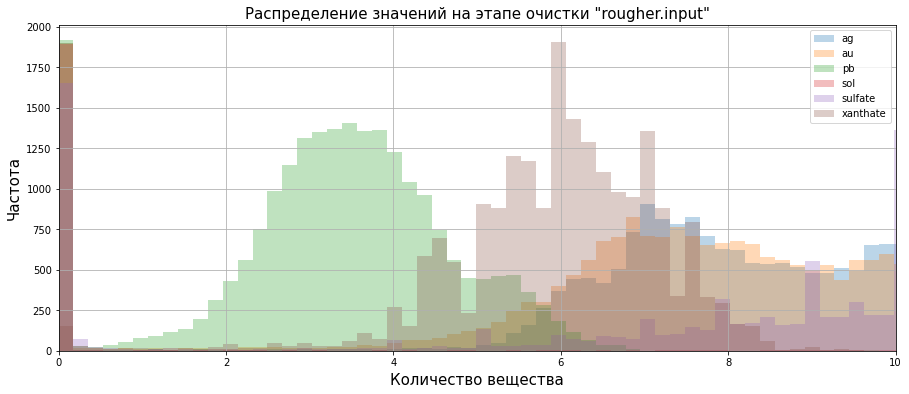

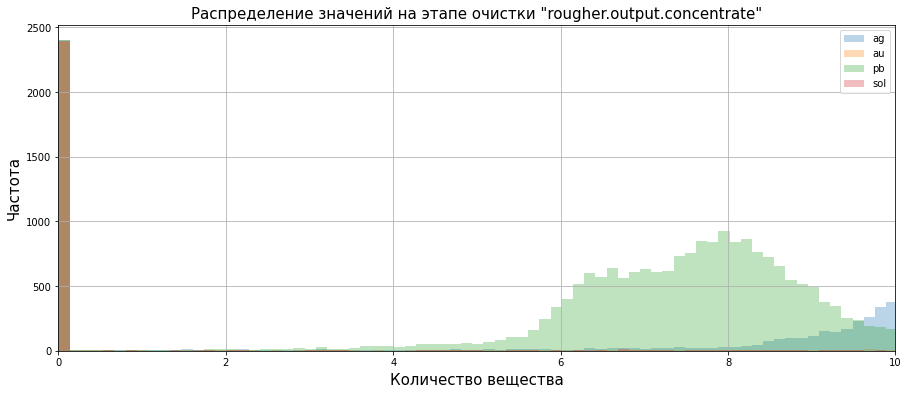

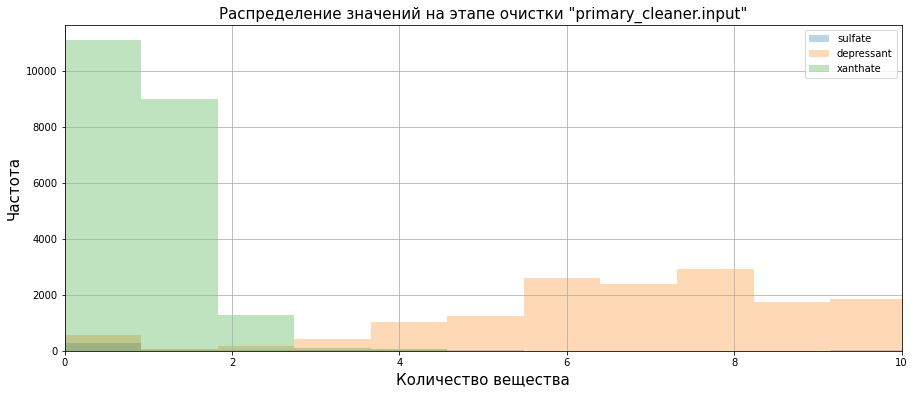

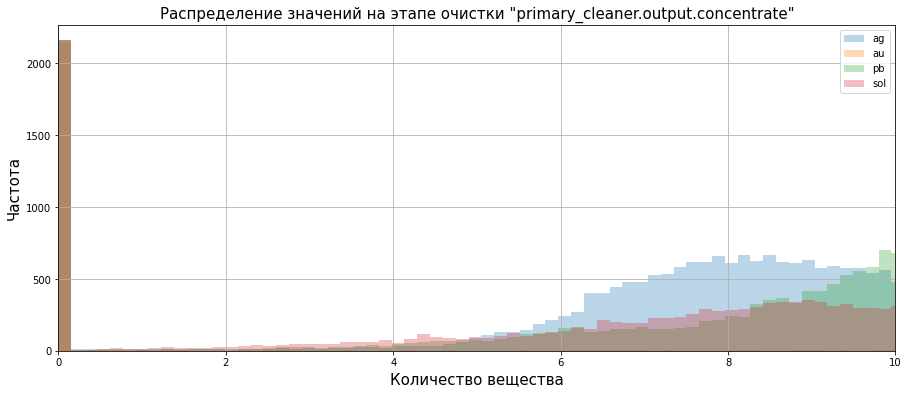

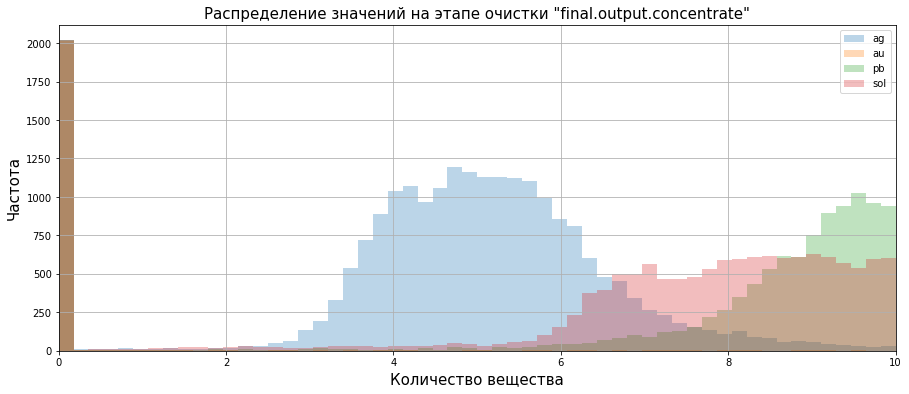

In [30]:
for data in values_concentrate_dict:
    values_concentrate_dict[data].plot(kind = 'hist', figsize=(15,6),bins = 300, alpha=0.3)
    plt.xlim([0,10])
    plt.xlabel('Количество вещества', fontsize=15)
    plt.ylabel('Частота',fontsize=15)
    plt.title(f'Распределение значений на этапе очистки "{data}"', fontsize=15)
    plt.grid()
    plt.show()

Предположение подтвердилось. Присутствует большое количество нулевых значений на этапах очистки "rougher.input", "rougher.output.concentrate", "primary_cleaner.output.concentrate", "final.output.concentrate". Необходимо учесть, что данные признаки участвуют при расчете эффективности очистки. Оценим количество нулевых значений в целевых признаках.

In [31]:
print('В исходном наборе данных целевой признак "rougher.output.recovery" равен нулю в',
      len(data_full[data_full['rougher.output.recovery'] == 0]),
      'строках')
print('В исходном наборе данных целевой признак "final.output.recovery" равен нулю в',
      len(data_full[data_full['final.output.recovery'] == 0]),
      'строках')

В исходном наборе данных целевой признак "rougher.output.recovery" равен нулю в 419 строках
В исходном наборе данных целевой признак "final.output.recovery" равен нулю в 151 строках


Нулевые значения в данном случае можно считать аномалией. Необходимо удалить из наборов данных для обучения и тестирования строки в которых присутствуют нулевые значения в столбцах с целевым признаком или на этапах "rougher.input", "rougher.output.concentrate", "primary_cleaner.output.concentrate", "final.output.concentrate". Данные строки соответствую началу работы технологического процесса и не могут считаться нормальным состоянием системы.

Создадим список с указанием на столбцы из которых необходимо удалить нулевые значения. В данном случае это название этапа без окончания в котором содержится название вещества.

In [32]:
columns_drop_null = ["rougher.input", 
                     "rougher.output.concentrate", 
                     "primary_cleaner.output.concentrate", 
                     "final.output.concentrate", 
                     "rougher.output.recovery",
                     "final.output.recovery"]

Напишем функцию, которая перебирает указания на столбцы и получает из них список полных названий столбцов.

In [33]:
def columns_with_null (data,columns_list):
    columns_with_null = []
    for selected_column in columns_list:
        for column in data:
            if column.startswith(selected_column):
                columns_with_null.append(column)
    return columns_with_null

Напишем функцию, которая определяет индексы строк с нулевыми значения хотя бы в одном из столбцов. Функция последовательно сохраняет в единый список все индексы, а потом убирает дубликаты.

In [34]:
def null_rows_indexs (data,columns_list):
    null_rows_indexs_list = []
    selected_columns = columns_with_null(data,columns_list)
    for column in selected_columns:
        drop_index = list(data.loc[data[column] == 0].index)
        null_rows_indexs_list.extend(drop_index)
        null_rows_indexs_list = list(set(null_rows_indexs_list))
    return null_rows_indexs_list

Применим функции к обучающему и тестовому набору данных и получим списки индексов.

In [35]:
drop_null_list_train_updated = null_rows_indexs(data_train_updated,columns_drop_null)
drop_null_list_test_updated = null_rows_indexs(data_test_updated,columns_drop_null)

Последовательно удалим строки используя список индексов.

In [36]:
data_train_updated = data_train_updated.drop(data_train_updated.index[drop_null_list_train_updated])
data_test_updated = data_test_updated.drop(data_test_updated.index[drop_null_list_test_updated])

##### 1.5.1 Вывод.<a id='step1.5.1'></a>

Исследование концентрации веществ на стадиях очистки показало наличие большое количество аномальных значений. В исходном наборе данных присутствует большое количество нулевых значений. Было принято решение удалить из обучающего и тестового наборов данных строки по списку столбцов относящихся к технологическому процессу очистки. Предположительно нулевые значения появляются в момент запуска процесса очистки когда в емкости для замера еще не поступили материалы.

#### 1.6 Сравнение распределения размеров гранул сырья на обучающем и тестовом наборе данных.<a id='step1.6'></a>

От заказчика поступила задача сравнить распределения размера гранул сырья на обучающем и тестовом наборе данных. Проанализируем графики распределения значений признаков "rougher.input.feed_size" и "primary_cleaner.input.feed_size". Сохраним в список "boxplot_columns_list" столбцы для сравнения. Таблицы для анализа сохранены в список "source_data_updated_list"

In [37]:
boxplot_columns_list = ['rougher.input.feed_size','primary_cleaner.input.feed_size']

In [38]:
data_test_updated.name = 'data_test_updated'
data_train_updated.name = 'data_train_updated'

source_data_updated_list = [data_test_updated, data_train_updated]

Построим графики распределения.

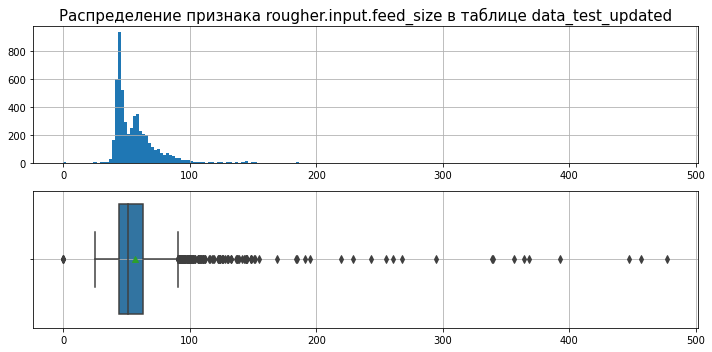

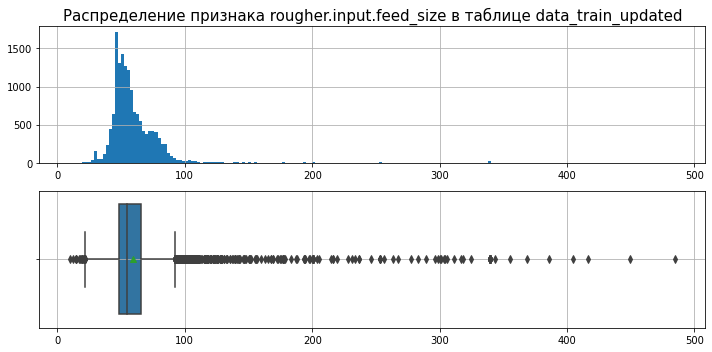

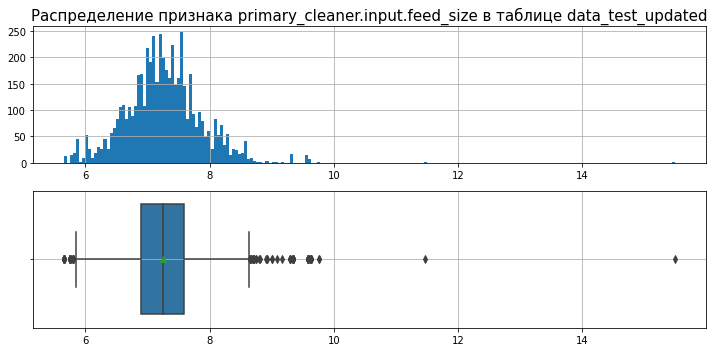

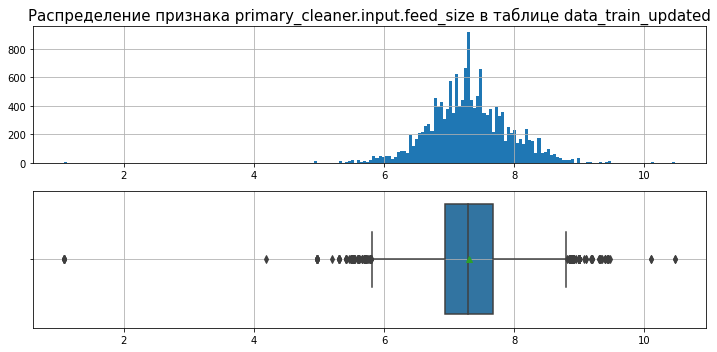

In [39]:
for column in boxplot_columns_list:
    for data in source_data_updated_list:
        fig, axes = plt.subplots(2,1,figsize=(10,5))
        axes[0].hist(data[column], bins = 200)
        axes[0].grid()
        axes[0].set_title(f'Распределение признака {column} в таблице {data.name}',fontsize=15)
        sns.boxplot(x=column, data=data, orient="h",showmeans=True).set(xlabel=None)
        fig.tight_layout()
        plt.grid()
        plt.show()

Признак "rougher.input.feed_size" распределен одинаково в обучающем и тестовом наборе. В обоих случах среднее значение равняется примерно 50. Диапазон значений судя по графику так же совпадает.

Распределение признака "primary_cleaner.input.feed_size" так же принимают схожие значения, но в тестовом наборе присутствует большое количество выбросов в большую сторону, тогда как в обучающем присутствуют выбросы в меньшую сторону. Необходимо исключить из наборов данных единичные выбросы. Оставим только значения в пределах от 5 до 10. Напишем функцию, которая позволит оставить только значения в интервале.

In [40]:
def leave_only_in_interval(data,column,interval):
    data_in_interval = data.loc[(data[column] >=interval[0]) &  (data[column] <=interval[1])]
    return data_in_interval

In [41]:
data_train_updated = leave_only_in_interval(data_train_updated,'primary_cleaner.input.feed_size',[5,10])
data_test_updated = leave_only_in_interval(data_test_updated,'primary_cleaner.input.feed_size',[5,10])

Оценим распределения после внесения корректировок. Перезапишем обновленные данные в список "source_data_updated_list" и сформируем графики.

In [42]:
data_test_updated.name = 'data_test_updated'
data_train_updated.name = 'data_train_updated'

source_data_updated_list = [data_test_updated, data_train_updated]

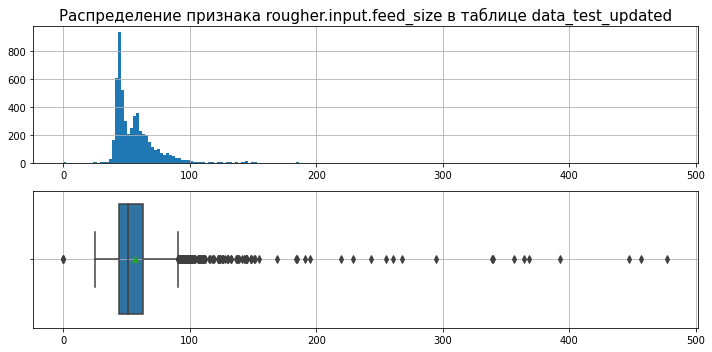

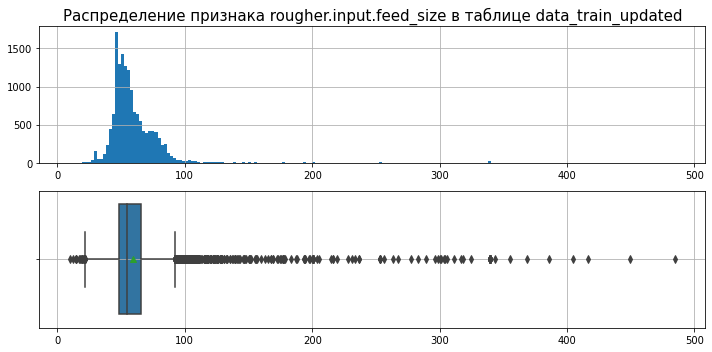

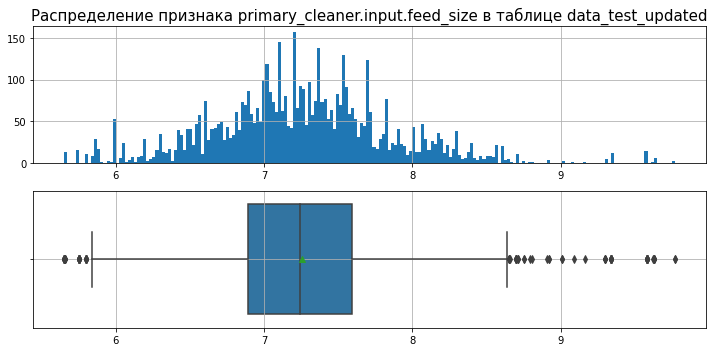

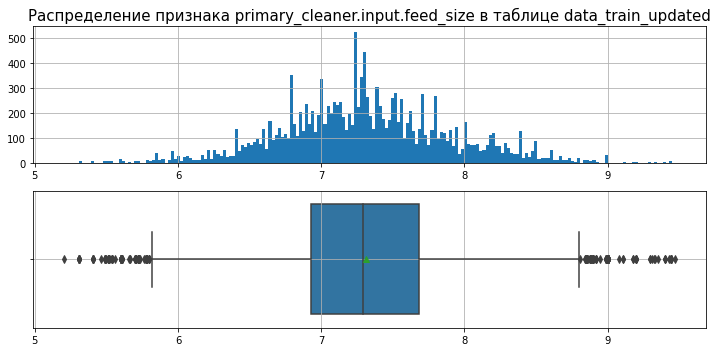

In [43]:
for column in boxplot_columns_list:
    for data in source_data_updated_list:
        fig, axes = plt.subplots(2,1,figsize=(10,5))
        axes[0].hist(data[column], bins = 200)
        axes[0].grid()
        axes[0].set_title(f'Распределение признака {column} в таблице {data.name}',fontsize=15)
        sns.boxplot(x=column, data=data, orient="h",showmeans=True).set(xlabel=None)
        fig.tight_layout()
        plt.grid()
        plt.show()

Распределения в обучающем и тестовом наборах данных имеют схожий характер после удаления выбросов.

### 2. Предобработка данных.<a id='step2'></a>

На этапе предварительного анализа были внесены изменения в обучающей и тестовый наборы данных.
Из обучающего набора данных были исключены признаки которые можно получить только после анализа сплавов. Оставлены только признаки из тестового набора данных и целевые признаки.
Тестовый набор был обогащен целевыми признаками.

Так же из наборов данных были исключены нулевые значения и явные выбросы в признаке "primary_cleaner.input.feed_size".
Для последующего обучения моделей необходимо выполнить еще ряд корректировок:

1. Избавится от пропущенных значений.
2. Разделить наборы данных на признаки относящиеся к флотации и очистке.
3. Проверить признаки на мультиколлинеарность.
4. Выполнить масштабирование значений.

Дальнейшая работа будет выполняться с таблицами из списка "source_data_updated_list"

#### 2.1 Обработка пропущенных значений. <a id='step2.1'></a>

Оценим количество пропущенных значений в таблицах. Напишем функцию, которая будет выдавать данные о пропусках в удобочитаемом виде. Функция сортирует столбцы в соответствии с количеством пропущенных значений.

In [44]:
def na_values (data):
    report = data.isna().sum().to_frame()
    report = report.rename(columns = {0: 'missing_values'})
    report['% of total'] = (report['missing_values'] / data.shape[0]).round(2)
    return report.sort_values(by = 'missing_values', ascending = False)

In [45]:
na_values(data_test_updated)

,missing_values,% of total
rougher.output.recovery,155,0.03
final.output.recovery,71,0.01
rougher.input.feed_sol,59,0.01
rougher.input.floatbank11_xanthate,49,0.01
primary_cleaner.input.depressant,29,0.01
secondary_cleaner.state.floatbank3_a_air,28,0.01
rougher.input.floatbank10_sulfate,26,0.00
primary_cleaner.input.xanthate,25,0.00
primary_cleaner.input.sulfate,25,0.00
rougher.input.feed_rate,23,0.00


In [46]:
na_values(data_train_updated)

,missing_values,% of total
rougher.output.recovery,1381,0.09
rougher.input.floatbank11_xanthate,858,0.06
rougher.state.floatbank10_e_air,493,0.03
primary_cleaner.input.sulfate,479,0.03
rougher.input.floatbank10_sulfate,451,0.03
rougher.input.floatbank11_sulfate,401,0.03
primary_cleaner.input.depressant,362,0.02
primary_cleaner.input.xanthate,355,0.02
final.output.recovery,339,0.02
secondary_cleaner.state.floatbank2_a_air,315,0.02


Большинство пропущенных значений приходится на целевые признаки. Можно предположить, что пропуски появляются в связи с тем что по технологическому процессу получить значение признаков можно только в конце процесса и на момент создания строки данные еще не поступили. Заполнять значения целевого признака каким либо алгоритмом будет не корректно. Такие изменения приведут к ухудшению качества предсказания самой модели и оценки качество при подборе гипперпараметров.

В не целевых признаках пропущенных значений немного. Заполним все пропущенные значения в не целевых признаках методом fillna(method='ffill'). Данный метод заполняет пропуск значением которое было до него. Для близких временных замеров должны быть близкие значения.
    
Удалим строки с пропущенными значениями в целевом признаке только после заполнения пропущенных значений в не целевых признаках. Удаление строк до заполнения может незначительно скорректировать порядок строк по времени.

Сохраним список с названиями целевых признаков.

In [47]:
target_features_list = ['final.output.recovery', 'rougher.output.recovery']

Применим метод fillna(method='ffill') к не целевым признакам.

In [48]:
data_test_updated[data_test_updated.columns.difference(target_features_list)] = \
    data_test_updated[data_test_updated.columns.difference(target_features_list)].fillna(method='ffill')

data_train_updated[data_train_updated.columns.difference(target_features_list)] = \
    data_train_updated[data_train_updated.columns.difference(target_features_list)].fillna(method='ffill')

После заполнения можно удалить все оставшиеся строки с пропущенными значениями.

In [49]:
data_test_updated = data_test_updated.dropna()
data_train_updated  = data_train_updated.dropna()

#### 2.2 Получение наборов данных согласно этапам технологического процесса. <a id='step2.2'></a>

Технологический процесс разделен на два этапа - флотация и очистка. Согласно требованию заказчика необходимо построить модель для каждого этапа. Разделим наборы данных для обучения и тестирования по этапам. Создадим два списка в которых будут содержаться названия столбцов относящихся к первому и второму этапу.

Обучающий и тестовый наборы данных содержат одинаковый набор признаков, не принципиально откуда получить список этапов.

In [50]:
rougher_columns = []
cleaner_columns = []

for column in list(data_train_updated):
    if 'rougher' in column:
        rougher_columns.append(column)
    else:
        cleaner_columns.append(column)        

Разделим таблицы на два этапа согласно спискам полученным выше.

In [51]:
data_test_updated_rougher = data_test_updated[rougher_columns]
data_test_updated_cleaner = data_test_updated[cleaner_columns]
data_train_updated_rougher = data_train_updated[rougher_columns]
data_train_updated_cleaner = data_train_updated[cleaner_columns]

Удалим из таблиц с данными по этапам очистки столбец "date".

In [52]:
data_test_updated_cleaner = data_test_updated_cleaner.drop("date",axis=1)
data_train_updated_cleaner = data_train_updated_cleaner.drop("date",axis=1)

#### 2.3 Проверка признаков на мультиколлинеарность. <a id='step2.3'></a>

На примере обучающего набора данных этапа флотации определим признаки с очень высоким значением коэффициента Пирсона. Очень высоким считается значение больше 0.75 или меньше -0.75. По итогам проверки напишем функцию для автоматизации процесса.

Получим DataFrame в котором попарно рассчитан коэффициент Пирсона по каждому признаку методом ".corr()". Затем преобразуем многоуровневую таблицу в виде попарных записей методом ".unstack()" и сбросим индексы. Изменения сохраним в переменную "data_corr_testing"

In [53]:
data_corr_testing = data_train_updated_rougher.corr().unstack().reset_index()

Скорректируем названия столбцов для удобства.

In [54]:
data_corr_testing.columns = ['feature_a','feature_b','corr_value']

Отфильтруем таблицу и выберем только значения в очень высокой прямой или обратной корреляцией. Так же уберем строки, где коэффициент равен единице. Значение коэффициента равно единицу в строках с зависимостью признака от самого себя.

In [55]:
data_corr_testing = data_corr_testing.query('(corr_value != 1) and ((corr_value <= -0.75) or (corr_value >= 0.75))')

Из полученной таблицы уберем строки с одинаковым значением коэффициента. Это строки отображают одинаковую зависимость и отличаются только порядков признаков.

In [56]:
data_corr_testing = data_corr_testing.drop_duplicates(subset=['corr_value'])

In [57]:
data_corr_testing

,feature_a,feature_b,corr_value
5,rougher.input.feed_ag,rougher.input.feed_au,0.843446
146,rougher.input.floatbank10_sulfate,rougher.input.floatbank11_sulfate,0.793792
170,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_xanthate,0.799236
314,rougher.state.floatbank10_b_air,rougher.state.floatbank10_c_air,0.935043
316,rougher.state.floatbank10_b_air,rougher.state.floatbank10_d_air,0.926476
318,rougher.state.floatbank10_b_air,rougher.state.floatbank10_e_air,0.829463
320,rougher.state.floatbank10_b_air,rougher.state.floatbank10_f_air,0.822009
338,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_level,0.987748
340,rougher.state.floatbank10_b_level,rougher.state.floatbank10_d_level,0.977676
342,rougher.state.floatbank10_b_level,rougher.state.floatbank10_e_level,0.973243


Прослеживается явная зависимость признаков. Если параметр "rougher.state.floatbank10_b_air" высокий, то и параметры "rougher.state.floatbank10_c_air", "rougher.state.floatbank10_d_air", "rougher.state.floatbank10_e_air", "rougher.state.floatbank10_f_air" так же высокие. Не принципиально из какого столбца выбрать признаки для удаления. Сохраним признаки из столбца "feature_a" и уберем из него дубликаты.

In [58]:
data_corr_testing_feature = data_corr_testing.drop_duplicates(subset=['feature_a'])['feature_a']

In [59]:
data_corr_testing_feature

5                   rougher.input.feed_ag
146     rougher.input.floatbank10_sulfate
170    rougher.input.floatbank10_xanthate
314       rougher.state.floatbank10_b_air
338     rougher.state.floatbank10_b_level
362       rougher.state.floatbank10_c_air
386     rougher.state.floatbank10_c_level
410       rougher.state.floatbank10_d_air
434     rougher.state.floatbank10_d_level
458       rougher.state.floatbank10_e_air
482     rougher.state.floatbank10_e_level
Name: feature_a, dtype: object

Из наборов данных этапа флотации необходимо исключить признаки содержащиеся в серии "data_corr_testing_feature".

Напишем функцию, которая позволит получить аналогичный список для этапа очистки.

In [60]:
def features_high_corr(data):
    data_corr = data.corr().unstack().reset_index()
    data_corr.columns = ['feature_a','feature_b','corr_value']
    data_corr_high = data_corr.query('(corr_value != 1) and \
            ((corr_value <= -0.75) or (corr_value >= 0.75))').drop_duplicates(subset=['corr_value'])
    data_corr_high_features = data_corr_high.drop_duplicates(subset=['feature_a'])['feature_a']
    return list(data_corr_high_features)

In [61]:
rougher_high_corr_features_list = features_high_corr(data_train_updated_rougher)
cleaner_high_corr_features_list = features_high_corr(data_train_updated_cleaner)

Удалим из наборов данных признаки согласно спискам.

In [62]:
data_test_updated_rougher = data_test_updated_rougher.drop(rougher_high_corr_features_list, axis=1)
data_test_updated_cleaner = data_test_updated_cleaner.drop(cleaner_high_corr_features_list, axis=1)
data_train_updated_rougher = data_train_updated_rougher.drop(rougher_high_corr_features_list, axis=1)
data_train_updated_cleaner = data_train_updated_cleaner.drop(cleaner_high_corr_features_list, axis=1)

Оценим размеры таблиц после удаление признаков с высокой коллинеарностью значений.

In [63]:
print("Размер таблиц тестового набора данных:")
print(data_test_updated_rougher.shape)
print(data_test_updated_cleaner.shape)
print("Размер таблиц обучающего набора данных:")
print(data_train_updated_rougher.shape)
print(data_train_updated_cleaner.shape)

Размер таблиц тестового набора данных:
(5152, 12)
(5152, 19)
Размер таблиц обучающего набора данных:
(13770, 12)
(13770, 19)


#### 2.4. Отделение целевого признака от обучающих. <a id='step2.4'></a>

Необходимо сохранить масштаб целевого признака. Дальнейшее масштабирование будет проводиться только на обучающих признаках. Отделим целевой признак от обучающих. Напишем функцию "feature_separation". Функция будет принимать в качестве параметров набор данных и название столбца с целевым признаком. После выполнения функция вернет разделенные данные сохраненные в словарь.

In [64]:
def feature_separation(data,target_column):
    data_dict_local = {}
    features = data.drop([target_column], axis=1)
    target = data[target_column]
    data_dict_local['target'] = target
    data_dict_local['features'] = features
    return data_dict_local

In [65]:
data_test_updated_rougher_dict = feature_separation(data_test_updated_rougher,'rougher.output.recovery')
data_test_updated_cleaner_dict = feature_separation(data_test_updated_cleaner,'final.output.recovery')
data_train_updated_rougher_dict = feature_separation(data_train_updated_rougher,'rougher.output.recovery')
data_train_updated_cleaner_dict = feature_separation(data_train_updated_cleaner,'final.output.recovery')

#### 2.5 Масштабирование признаков. <a id='step2.5'></a>

Численные признаки имеют различный масштаб, что может повлиять на качество модели. Создадим объект структуры StandardScaler() и настроим его используя обучающий набор данных. Настройка — это вычисление среднего и дисперсии. Так как у нас два этапа с различными данными, то перед каждым масштабированием необходимо переобучить StandardScaler() на новых данных. Как было указано ранее масштабироваться будут только признаки для обучения.

In [66]:
scaler = StandardScaler()

Напишем функцию для масштабирования.

In [67]:
def transform_data_dicts(data_dict_train,data_dict_test):
    column_list = list(data_dict_train['features'])
    scaler.fit(data_dict_train['features'][column_list])
    data_dict_train['features'][column_list] = scaler.transform(data_dict_train['features'][column_list])
    data_dict_test['features'][column_list] = scaler.transform(data_dict_test['features'][column_list])

Выполним функцию для всех словарей с данными.

In [68]:
transform_data_dicts(data_train_updated_rougher_dict, data_test_updated_rougher_dict)
transform_data_dicts(data_train_updated_cleaner_dict, data_test_updated_cleaner_dict)

### 3. Построение моделей. <a id='step3'></a>

#### 3.1 Функция расчета sMAPE. <a id='step3.1'></a>

Для решения задачи введём новую метрику качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).
Метрика sMAPE вычисляется по следующей формуле:

$sMAPE = \frac{1}{N} \sum\limits_{i=1}^N \frac{|y_i-\hat{y_i}|}{(|y_i|+|\hat{y_i}|)/2} *100\%$

Обозначения:
<br>$y_i$ -Значение целевого признака для объекта с порядковым номером i в выборке, на которой измеряется качество.
<br>$\hat{y_i}$ - Значение предсказания для объекта с порядковым номером i.
<br>N - Количество объектов в выборке.
<br>$\sum\limits_{i=1}^N$ - Суммирование по всем объектам выборки (i меняется от 1 до N).

Итоговая метрика складывается из двух величин:

Итоговая sMAPE = 25% * sMAPE(rougher) + 75% * sMAPE(cleaner)

Напишем функцию для расчета sMAPE.

In [69]:
def smape(target, predict):
    return 100 * (2 * np.abs(target - predict) / (np.abs(target) + np.abs(predict))).mean()

#### 3.2 Поиск оптимальной модели и гиперпараметров. <a id='step3.2'></a>

Необходимо подобрать оптимальную модель и гиперпараметры к ней. Создадим список моделей которые мы будем использовать.

In [70]:
models_types_list = [DecisionTreeRegressor(random_state=12345),RandomForestRegressor(random_state=12345),LinearRegression()]

Создадим словари с параметрами для моделей "дерево решений" и "случайный лес". Линейная регрессия не предусматривает сложных гиперпараметров.

In [71]:
parametrs_tree = { 'max_depth': range (1, 5) }
parametrs_forest = { 'n_estimators': range (10, 101, 10),
              'max_depth': range (1, 5) }

Напишем небольшую функцию для автоматизации. Функция принимает в качестве параметров модель, DataFrame и словарь с параметрами. Функция возвращает наилучшие значения гипперпараметров.

In [72]:
def grid_search(model,data,parametrs):
    grid = GridSearchCV(model,
                                 parametrs,
                                 scoring=make_scorer(smape, greater_is_better=False),
                                 cv=5)
    grid.fit(data['features'],data['target'])
    print(f'Лучшие гиперпараметры для модели {model} - {grid.best_params_}')

Подберем наилучшие гиперпараметры используя "GridSearchCV" для этапа флотации. 

In [73]:
%%time
grid_search(DecisionTreeRegressor(random_state=12345),
            data_train_updated_rougher_dict,
            parametrs_tree)

Лучшие гиперпараметры для модели DecisionTreeRegressor(random_state=12345) - {'max_depth': 2}
Wall time: 914 ms


In [74]:
%%time
grid_search(RandomForestRegressor(random_state=12345),
            data_train_updated_rougher_dict,
            parametrs_forest)

Лучшие гиперпараметры для модели RandomForestRegressor(random_state=12345) - {'max_depth': 4, 'n_estimators': 100}
Wall time: 4min 31s


Подберем наилучшие гиперпараметры используя для этапа очистки.

In [75]:
%%time
grid_search(DecisionTreeRegressor(random_state=12345),
            data_train_updated_cleaner_dict,
            parametrs_tree)

Лучшие гиперпараметры для модели DecisionTreeRegressor(random_state=12345) - {'max_depth': 1}
Wall time: 1.62 s


In [76]:
%%time
grid_search(RandomForestRegressor(random_state=12345),
            data_train_updated_cleaner_dict,
            parametrs_forest)

Лучшие гиперпараметры для модели RandomForestRegressor(random_state=12345) - {'max_depth': 1, 'n_estimators': 20}
Wall time: 7min 9s


##### 3.2.1 Вывод. <a id='step3.2.1'></a>

Наилучшие гиперпараметры для этапа флотации:
"Дерево решений" - {'max_depth': 2}
"Случайный лес" - {'max_depth': 4, 'n_estimators': 100}
Наилучшие гиперпараметры для этапа очистки:
"Дерево решений" - {'max_depth': 1}
"Случайный лес" - {'max_depth': 1, 'n_estimators': 20}

#### 3.3 Расчет качества моделей на обучающем наборе данных. <a id='step3.3'></a>

Рассчитаем какая модель лучше всего подходит для предсказания эффективности очистки для каждого этапа и напишем функцию. В качестве параметра качества будем использовать sMAPE. Чтобы более точного расчета sMAPE воспользуемся кросс-валидацией и функцией "cross_val_score". В качестве параметра "scoring" мы передадим функцию "smape" написанную ранее. Таким образом мы сможем сразу получить значения sMAPE для каждой модели.
    
Функция принимать в качестве параметров словарь с данными и модель.

In [77]:
def smape_score(data_dict,model):
    scores = cross_val_score(model, 
                         data_dict['features'], 
                         data_dict['target'], 
                         scoring=make_scorer(smape, greater_is_better=False), cv=5)
    final_score = abs(sum(scores)/len(scores))
    print(f'Значение среднего sMAPE для модели {model}:\n{final_score}')

##### 3.3.1 Линейная регресия. <a id='step3.3.1'></a>

Линейная регрессия не предусматривает сложных гиперпараметров. Проверим какое среднее значение sMAPE можно получить на данных этапа флотации.

In [78]:
%%time
smape_score(data_train_updated_rougher_dict,LinearRegression())

Значение среднего sMAPE для модели LinearRegression():
6.634547269424985
Wall time: 79 ms


Проверим модель на данных этапа очистки.

In [79]:
%%time
smape_score(data_train_updated_cleaner_dict,LinearRegression())

Значение среднего sMAPE для модели LinearRegression():
10.260675099089681
Wall time: 93 ms


##### 3.3.2 Дерево решений. <a id='step3.3.2'></a>

Ранее мы получили наилучшие гиперпараметры для модели "дерево решений".
<br>Наилучшие гиперпараметры для этапа флотации: 
<br>{'max_depth': 2}
<br>Наилучшие гиперпараметры для этапа очистки:
<br>{'max_depth': 1}

Рассчитаем среднее sMAPE для этапа флотации.

In [80]:
%%time
smape_score(data_train_updated_rougher_dict,
            DecisionTreeRegressor(random_state=12345, max_depth=2))

Значение среднего sMAPE для модели DecisionTreeRegressor(max_depth=2, random_state=12345):
7.448185074359708
Wall time: 226 ms


Рассчитаем среднее sMAPE для этапа очистки.

In [81]:
%%time
smape_score(data_train_updated_cleaner_dict,
            DecisionTreeRegressor(random_state=12345, max_depth=1))

Значение среднего sMAPE для модели DecisionTreeRegressor(max_depth=1, random_state=12345):
10.144051129821653
Wall time: 140 ms


##### 3.3.3 Случайный лес. <a id='step3.3.3'></a>

Ранее мы получили наилучшие гиперпараметры для модели "случайный лес". 
<br>Наилучшие гиперпараметры для этапа флотации: 
<br>{'max_depth': 4, 'n_estimators': 100} 
<br>Наилучшие гиперпараметры для этапа очистки: 
<br>{'max_depth': 1, 'n_estimators': 20}

Рассчитаем среднее sMAPE для этапа флотации.

In [82]:
%%time
smape_score(data_train_updated_rougher_dict,
            RandomForestRegressor(random_state=12345,max_depth=4, n_estimators=100))

Значение среднего sMAPE для модели RandomForestRegressor(max_depth=4, random_state=12345):
7.180900797473498
Wall time: 19 s


Рассчитаем среднее sMAPE для этапа очистки.

In [83]:
%%time
smape_score(data_train_updated_cleaner_dict,
            RandomForestRegressor(random_state=12345,max_depth=1, n_estimators=20))

Значение среднего sMAPE для модели RandomForestRegressor(max_depth=1, n_estimators=20, random_state=12345):
10.004542221898152
Wall time: 1.95 s


##### 3.3.4 Вывод.  <a id='step3.3.4'></a>

Необходимо выбрать наименьшее значение. 

Наилучший результат для этапа флотации показала модель "линейная регрессия". 
Наилучший результат для этапа очистки показала модель "случайный лес" с гиперпараметрами "max_depth"=1 и "n_estimators"=20

#### 3.4 Проверка моделей на тестовом наборе данных. <a id='step3.4'></a>

Рассчитаем итоговую sMAPE на тестовом наборе данных используя наилучшие модели.
Напишем функцию, которая принимает в качестве параметров:
    
    - Модель с гиперпараметрами для этапа флотации
    - Модель с гиперпараметрами для этапа очистки
    - Обучающий набор данных этапа флотации
    - Обучающий набор данных этапа очистки
    - Тестовый набор данных этапа флотации
    - Тестовый набор данных этапа очистки

In [84]:
def final_smape(model_rougher_parametrs,
                model_cleaner_parametrs,
                data_train_rougher,
                data_train_cleaner,
                data_test_rougher,
                data_test_cleaner):
    
    #<этап флотации>
    model_rougher = model_rougher_parametrs
    model_rougher.fit(data_train_rougher['features'],data_train_rougher['target'])
    predictions_test_rougher = model_rougher.predict(data_test_rougher['features'])
    smape_rougher = smape(data_test_rougher['target'],predictions_test_rougher)
    #<этап очистки>
    model_cleaner = model_cleaner_parametrs
    model_cleaner.fit(data_train_cleaner['features'],data_train_cleaner['target'])
    predictions_test_cleaner = model_cleaner.predict(data_test_cleaner['features'])
    smape_cleaner = smape(data_test_cleaner['target'],predictions_test_cleaner)
    #<расчет итоговой smape>
    
    final_smape = (smape_rougher * 0.25) + (smape_cleaner * 0.75)
    print(f'Значение итоговой sMAPE на тестовом наборе данных:\n{final_smape}')  

In [85]:
final_smape(LinearRegression(),
            RandomForestRegressor(random_state=12345,max_depth=1, n_estimators=20),
            data_train_updated_rougher_dict,
            data_train_updated_cleaner_dict,
            data_test_updated_rougher_dict,
            data_test_updated_cleaner_dict)

Значение итоговой sMAPE на тестовом наборе данных:
6.834745636653477


Рассчитаем аналогичный параметр, но на простой модели "DummyRegressor". В качестве параметр будем использовать strategy= 'median'.  Данный параметр указывает, что модель всегда будет предсказывать медианное значение обучающего набора.

In [86]:
final_smape(DummyRegressor(strategy='median'),
            DummyRegressor(strategy='median'),
            data_train_updated_rougher_dict,
            data_train_updated_cleaner_dict,
            data_test_updated_rougher_dict,
            data_test_updated_cleaner_dict)

Значение итоговой sMAPE на тестовом наборе данных:
7.356355423901205


##### 3.4.1 Вывод.  <a id='step3.4.1'></a>

<br>У комбинации моделей "линейной регрессии" и "случайного леса" получена итоговая ошибка sMAPE - 6.83
<br>Итоговое значение sMAPE у простой модели со стратегией "median" - 7.35
    
Сложная модель оказалась эффективнее в предсказании целевых признаков чем простая модель. Обучение модели можно считать удачным.

### 4. Общий вывод. <a id='step4'></a>

Исследование концентрации веществ на стадиях очистки показало наличие большое количество аномальных значений. В исходном наборе данных присутствует большое количество нулевых значений. Было принято решение удалить из обучающего и тестового наборов данных строки по списку столбцов относящихся к технологическому процессу очистки. Предположительно нулевые значения появляются в момент запуска процесса очистки когда в емкости для замера еще не поступили материалы. Необходимо оповестить заказчика, что предоставленную модель предполагается использовать после выхода очистительной установки на нормальный режим.

Исследование концентрации металлов на различных этапах технологического процесса позволяет сделать следующие выводы:

    Золото:
    На каждом этапе очистки количество золота в пробах значительно увеличивается. После финальной стадии очистки количество золота в пробах в среднем увеличилось более чем в четыре раза.
    В среднем количество золота в отвалах значительно снижается относительно изначального количества в руде. При этом после каждого этапа очистки количество золота в отвалах примерно одинаковое. Незначительное увеличение количества золота в отвалах после первичной очистки можно связать с увеличением количества золота в концентрате который попадает на первичную очистку.

    Серебро:
    Относительно содержания в исходном сырье среднее количество серебра в концентрате после флотации увеличивается. На последующих этапах содержание серебра в концентрате падает.
    После первой стадии очистки количество серебра в отвалах резко увеличивается и становиться больше чем в исходном сырье.
    На всех этапах кроме флотации количество серебра в отвалах больше чем в исходном сырье.

    Свинец:
    Количество свинца в концентрате на всех стадиях очистки увеличивается относительно содержания в исходном сырье.
    Количество свинца в отвалах меняется не линейно. Больше всего свинца в отвалах после второго этапа очистки.


У комбинации моделей "линейной регрессии" и "случайного леса" получена итоговая ошибка sMAPE - 6.83
Данный показатель достигнул при следующих гиперпараметрах:
<br>Для этапа флотации использовалась модель "линейной регрессии".
<br>Для этапа очистки использовалась модель "случайный лес" с глубиной - 1 и количеством деревьев - 20

Итоговое значение sMAPE у простой модели со стратегией "median" - 7.35

Сложная модель оказалась эффективнее в предсказании целевых признаков чем простая модель. 
Обучение модели можно считать успешным.